In [7]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define the tickers and the time frame
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOGL']
start_date = '2015-01-01'
end_date = '2020-01-01'

# Retrieve historical data
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']


/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[                       0%%                      ]/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a 

In [8]:
import numpy as np

# Calculate the Rate of Change (ROC) to measure momentum
roc = data.pct_change(periods=20)  # 20-day ROC

# Calculate historical volatility (30-day standard deviation of returns)
volatility = data.pct_change().rolling(window=30).std()

# Inverse volatility for position sizing
inv_vol = 1 / volatility

# Normalize inverse volatility to sum to 1 across the stocks at each time point
inv_vol_normalized = inv_vol.div(inv_vol.sum(axis=1), axis=0)

# Generate signals: 1 for buy, 0 for neutral
# A simple approach: buy if ROC is positive, else neutral
signals = (roc > 0).astype(int)

# Adjust signals by the inverse volatility
weighted_signals = signals.multiply(inv_vol_normalized)


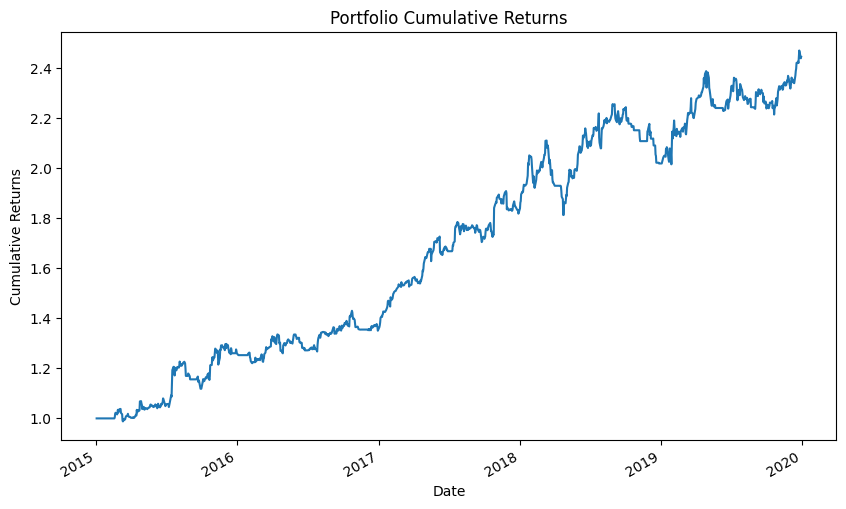

In [9]:
# Daily returns
daily_returns = data.pct_change()

# Portfolio returns: element-wise multiplication of signals and daily returns, sum across stocks
portfolio_returns = (weighted_signals.shift(1) * daily_returns).sum(axis=1)

# Cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
cumulative_returns.plot(figsize=(10,6))
plt.title('Portfolio Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.xlabel('Date')
plt.show()


In [10]:
# Annualized Return
annualized_return = cumulative_returns.iloc[-1]**(365/len(portfolio_returns)) - 1

# Annualized Volatility
annualized_volatility = portfolio_returns.std() * np.sqrt(252)

# Sharpe Ratio (assuming a risk-free rate of 0 for simplicity)
sharpe_ratio = annualized_return / annualized_volatility

print(f"Annualized Return: {annualized_return}")
print(f"Annualized Volatility: {annualized_volatility}")
print(f"Sharpe Ratio: {sharpe_ratio}")


Annualized Return: 0.29642282469155035
Annualized Volatility: 0.13434338827111106
Sharpe Ratio: 2.2064563690574457


In [18]:
import pandas as pd
import yfinance as yf
import requests
import pandas_ta as ta
import matplotlib.pyplot as plt
from termcolor import colored as cl
import math 

# Load AAPL data
aapl = yf.download('AAPL', start="2015-01-01", end="2020-01-01")



/Users/hanyuwu/Library/Caches/pypoetry/virtualenvs/compare-multiple-backtests-f1m3Q6xX-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [26]:
aapl[['dcl', 'dcm', 'dcu']] = aapl.ta.donchian(lower_length = 20, upper_length = 30)
aapl.tail()

,Open,High,Low,Close,Adj Close,Volume,dcl,dcm,dcu
Date,,,,,,,,,
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.147995,48478800,64.072502,67.647503,71.222504
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.519913,93121200,64.072502,68.283752,72.495003
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.493164,146266000,64.072502,68.782501,73.492500
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.911530,144114400,64.072502,68.782501,73.492500
2019-12-31,72.482498,73.419998,72.379997,73.412498,71.429657,100805600,64.072502,68.782501,73.492500


Text(0, 0.5, 'Close')

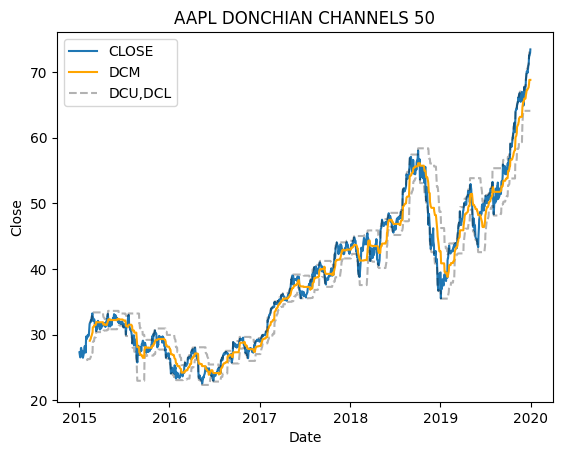

In [27]:
plt.plot(aapl.Close, label = 'CLOSE')
plt.plot(aapl.dcl, color = 'black', linestyle = '--', alpha = 0.3)
plt.plot(aapl.dcm, color = 'orange', label = 'DCM')
plt.plot(aapl.dcu, color = 'black', linestyle = '--', alpha = 0.3, label = 'DCU,DCL')
plt.legend()
plt.title('AAPL DONCHIAN CHANNELS 50')
plt.xlabel('Date')
plt.ylabel('Close')

In [28]:
import math
from termcolor import colored as cl

def implement_strategy(aapl, investment):
    
    in_position = False
    equity = investment
    
    for i in range(3, len(aapl)):
        if aapl['High'][i] == aapl['dcu'][i] and in_position == False:
            no_of_shares = math.floor(equity/aapl['Close'][i])
            equity -= (no_of_shares * aapl['Close'][i])
            in_position = True
            print(cl('BUY: ', color = 'green', attrs = ['bold']), f'{no_of_shares} Shares are bought at ${aapl["Close"][i]} on {str(aapl.index[i])[:10]}')
        elif aapl['Low'][i] == aapl['dcl'][i] and in_position == True:
            equity += (no_of_shares * aapl['Close'][i])
            in_position = False
            print(cl('SELL: ', color = 'red', attrs = ['bold']), f'{no_of_shares} Shares are sold at ${aapl["Close"][i]} on {str(aapl.index[i])[:10]}')
    if in_position == True:
        equity += (no_of_shares * aapl['Close'][i])
        print(cl(f'\nClosing position at {aapl["Close"][i]} on {str(aapl.index[i])[:10]}', attrs = ['bold']))
        in_position = False

    earning = round(equity - investment, 2)
    roi = round(earning / investment * 100, 2)
    print(cl(f'EARNING: ${earning} ; ROI: {roi}%', attrs = ['bold']))
    
implement_strategy(aapl, 100000)  # Uncomment this line when you have defined 'aapl'

BUY:  3129 Shares are bought at $31.957500457763672 on 2015-02-17
SELL:  3129 Shares are sold at $30.559999465942383 on 2015-03-11
BUY:  2949 Shares are bought at $32.41749954223633 on 2015-04-23
SELL:  2949 Shares are sold at $31.252500534057617 on 2015-05-06
BUY:  2792 Shares are bought at $33.01750183105469 on 2015-07-20
SELL:  2792 Shares are sold at $29.610000610351562 on 2015-08-03
BUY:  2777 Shares are bought at $29.770000457763672 on 2015-10-23
SELL:  2777 Shares are sold at $28.1200008392334 on 2015-12-14
BUY:  3077 Shares are bought at $25.375 on 2016-03-03
SELL:  3077 Shares are sold at $26.420000076293945 on 2016-04-22
BUY:  3253 Shares are bought at $24.989999771118164 on 2016-07-20
SELL:  3253 Shares are sold at $26.3799991607666 on 2016-09-08
BUY:  3071 Shares are bought at $27.9424991607666 on 2016-09-14
SELL:  3071 Shares are sold at $27.872499465942383 on 2016-11-01
BUY:  3022 Shares are bought at $28.325000762939453 on 2016-12-12
SELL:  3022 Shares are sold at $37.24

/var/folders/h1/rvjbcw3x19dcwnv6qxb4pxrm0000gn/T/ipykernel_4409/3694880898.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if aapl['High'][i] == aapl['dcu'][i] and in_position == False:
/var/folders/h1/rvjbcw3x19dcwnv6qxb4pxrm0000gn/T/ipykernel_4409/3694880898.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif aapl['Low'][i] == aapl['dcl'][i] and in_position == True:
/var/folders/h1/rvjbcw3x19dcwnv6qxb4pxrm0000gn/T/ipykernel_4409/3694880898.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with 